In [102]:
import pandas as pd

pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


In [103]:
data = pd.read_csv('Data/case_files.csv')
data.head()

Unnamed: 0 View Case Files                 Case Name  \
0           0      Case Files         USA v. Botsvynyuk   
1           1      Case Files               USA v. Kalu   
2           2      Case Files         USA v. Lee, et al   
3           3      Case Files  USA v. Leon-Aldana et al   
4           4      Case Files             USA v. Weston   

             Case Number  # of Defendants  # of Victims Case Type  \
0       2:10-cr-00159-PD                5          30.0     Labor   
1          1:12-cr-00106                2          18.0     Labor   
2  1:01-cr-00132-SOM-BMK                3          21.0     Labor   
3        3:07-cr-00035-L                4           9.0     Labor   
4      2:13-cr-00025-CMR                5          50.0     Labor   

                                        Case Summary  
0  The defendants, five Ukrainian brothers, recru...  
1  The defendants created an educational institut...  
2  The defendants operated a garment factory usin...  
3  The defendants were members of an alien smuggl...  
4  The defendant known as Linda Weston used cunni...

In [104]:
data_reduced = data[['Case Type', 'Case Summary']]
data_reduced = data_reduced.rename(columns = {'Case Type': 'class', 'Case Summary':'complain'})
data_reduced.head()

class                                           complain
0  Labor  The defendants, five Ukrainian brothers, recru...
1  Labor  The defendants created an educational institut...
2  Labor  The defendants operated a garment factory usin...
3  Labor  The defendants were members of an alien smuggl...
4  Labor  The defendant known as Linda Weston used cunni...

In [105]:
data_reduced = data_reduced.dropna()

In [106]:
data_reduced['complain'] = data_reduced.complain.apply(lambda x: x.lower())

In [107]:
data_reduced.head()

class                                           complain
0  Labor  the defendants, five ukrainian brothers, recru...
1  Labor  the defendants created an educational institut...
2  Labor  the defendants operated a garment factory usin...
3  Labor  the defendants were members of an alien smuggl...
4  Labor  the defendant known as linda weston used cunni...

In [108]:
data_reduced['class'].value_counts()

Minor    673
Adult    349
Labor    111
Name: class, dtype: int64

# word2vec modelling

In [109]:
import gensim

In [110]:
def build_corpus(data_reduced):
    "Creates a list of lists containing words from each sentence"
    sentences = data_reduced.complain.values.tolist()
    for sentence in sentences:
    
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    
    #return corpus

corpus = list(build_corpus(data_reduced))              


In [111]:
len(corpus)

1133

In [112]:
#corpus[0]

In [128]:
vecsize = 200
#not bad
#model = word2vec.Word2Vec(corpus, size=200, window=2, min_count=5, negative=1, workers = 4)#workers CPUs
model = word2vec.Word2Vec(corpus, size=100, window=2, min_count=1, negative=1, sample = 1e-3)#workers CPUs
#model.wv['slave']

In [129]:
len(model.wv.vocab)

3259

In [130]:
model.wv.similarity('labor', 'legitimate')

0.1347695

In [131]:
model.wv.similarity('labor', 'illegal')

0.06018162

In [133]:
model.wv.most_similar(positive=['work']) 

[('well', 0.3805134892463684),
 ('occasionally', 0.3791816830635071),
 ('prostitute', 0.37459123134613037),
 ('prostitutes', 0.3692581355571747),
 ('pimp', 0.3362746238708496),
 ('known', 0.323397159576416),
 ('parlors', 0.3225867450237274),
 ('recruit', 0.3199650049209595),
 ('all', 0.3112751245498657),
 ('then', 0.2958349585533142)]

In [134]:
from sklearn.decomposition import PCA
import seaborn as sns

In [135]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

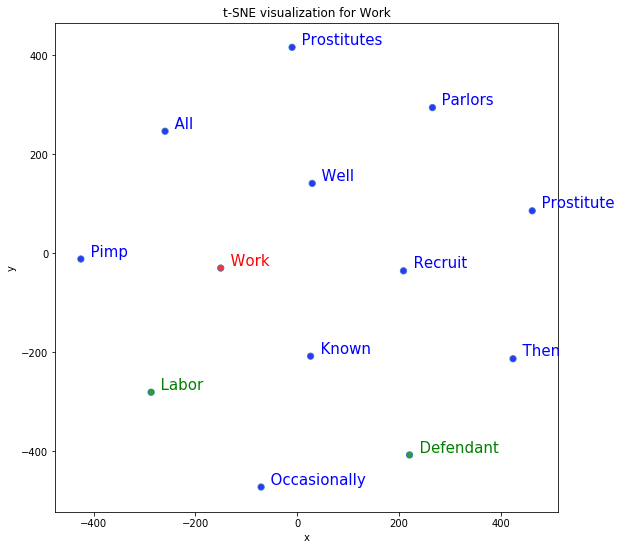

In [136]:
tsnescatterplot(model, 'work', ['labor','defendant'])
#try to do it interactive

# Word cloud

In [137]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

In [138]:
word_vectors =  model.wv

In [139]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [140]:
Z = model.wv.syn0;

print(Z[0].shape)
Z[0]

(100,)


/media/windows/Users/Afrokate/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


array([ 0.00644503,  0.01049918,  0.0082232 , -0.01412118, -0.00472919,
       -0.00495122, -0.00559604, -0.00497504, -0.00861488, -0.0217112 ,
        0.00367001, -0.00257137, -0.00696193, -0.01300554, -0.00371673,
        0.0156097 , -0.02074975,  0.00832521, -0.01262562, -0.01611751,
       -0.00500527,  0.00399644,  0.02230637, -0.00180675,  0.00281511,
       -0.007283  ,  0.00563884,  0.00036538, -0.01275942,  0.01058443,
       -0.01536964,  0.01385098, -0.01572331, -0.00283495,  0.00137772,
       -0.00914016, -0.01105427,  0.0049927 ,  0.01382846,  0.00966171,
       -0.00781163,  0.01133357,  0.00233409,  0.0006577 ,  0.03030467,
        0.00581572,  0.0019126 , -0.02217195,  0.00975189,  0.00881131,
        0.01615535,  0.00602781,  0.00375721,  0.01259622, -0.0148844 ,
       -0.00268411,  0.02788689, -0.01263093, -0.0038533 , -0.015394  ,
        0.00882063, -0.01039157,  0.00006906,  0.00190117, -0.00208843,
        0.02699155, -0.00732092,  0.00147183, -0.00960193, -0.01

In [163]:
centers, clusters = clustering_on_wordvecs(Z, 4);
centroid_map = dict(zip(model.wv.index2word, clusters));

In [164]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster num' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]

#A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [165]:
 ccc = [KDTree(Z).query(np.reshape(x, (1, -1)), k=100) for x in centers];

In [166]:
len((ccc[1][1][0]))

100

In [167]:
top_words = get_top_words(model.wv.index2word, 100, centers, Z);

In [168]:
top_words.columns

Index(['Cluster num0', 'Cluster num1', 'Cluster num2', 'Cluster num3'], dtype='object')

In [169]:
#!pip install wordcloud

In [170]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num0'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

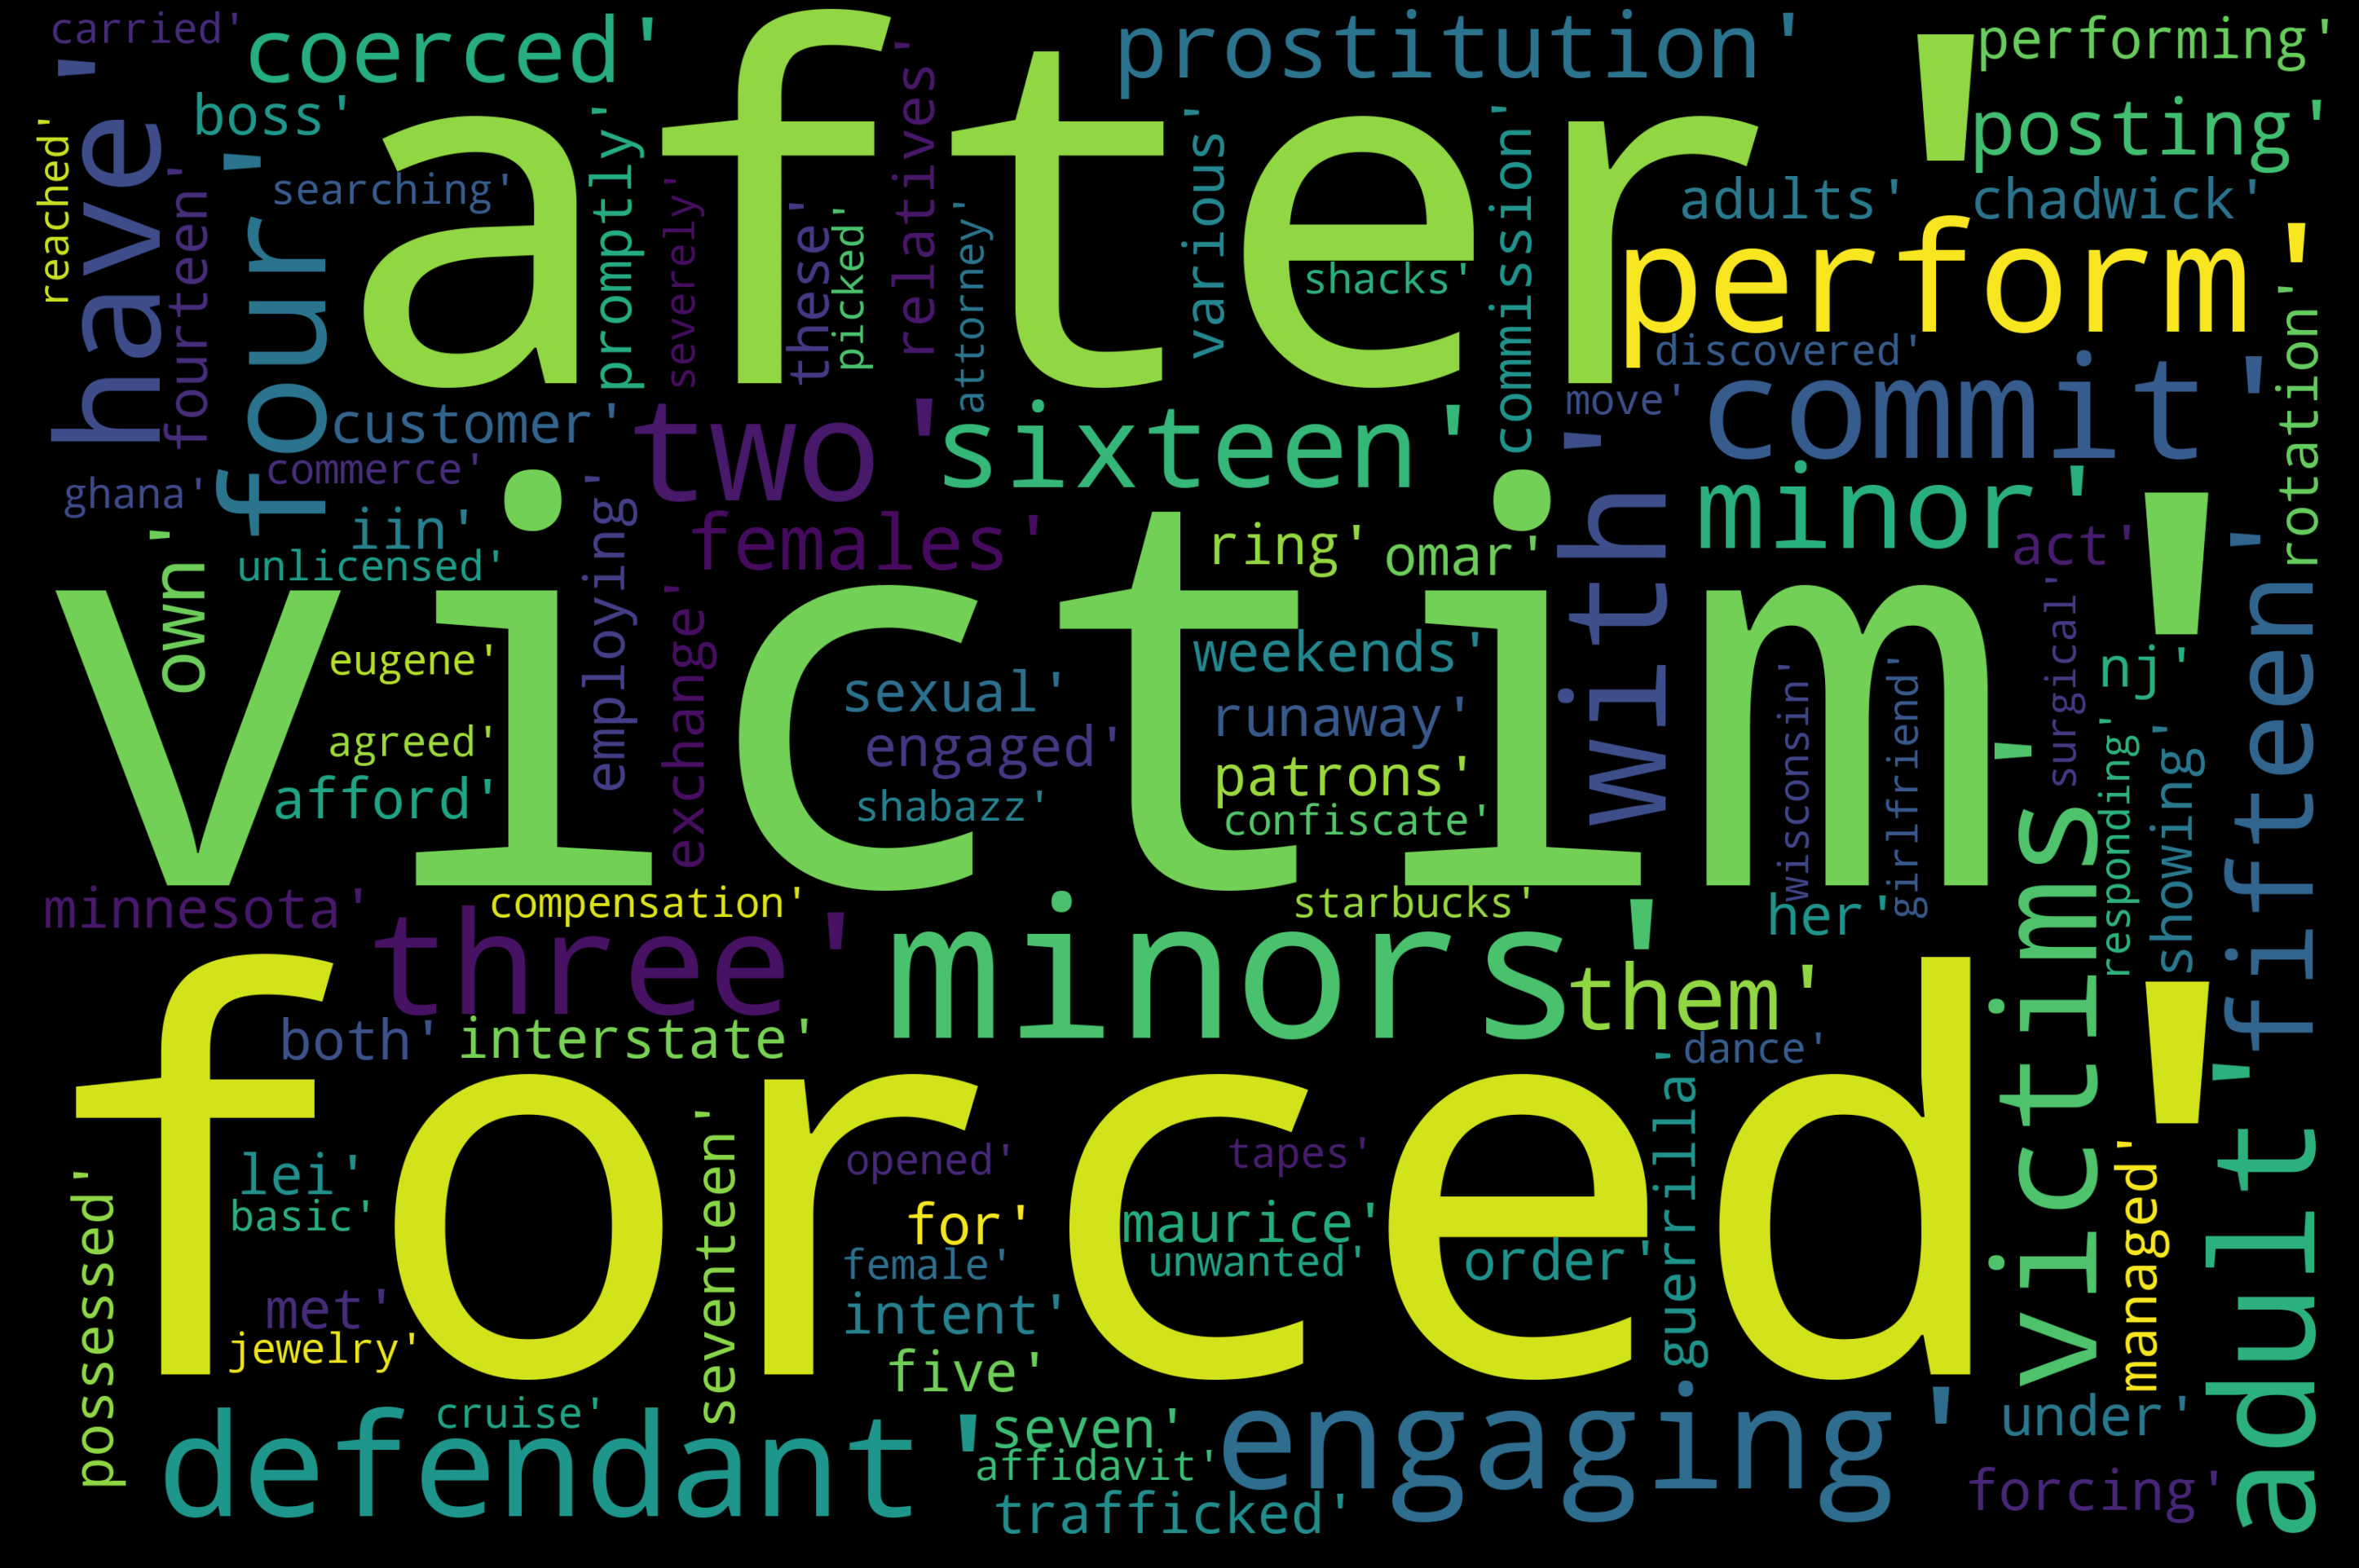

In [176]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num1'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig('negative_1.jpg')

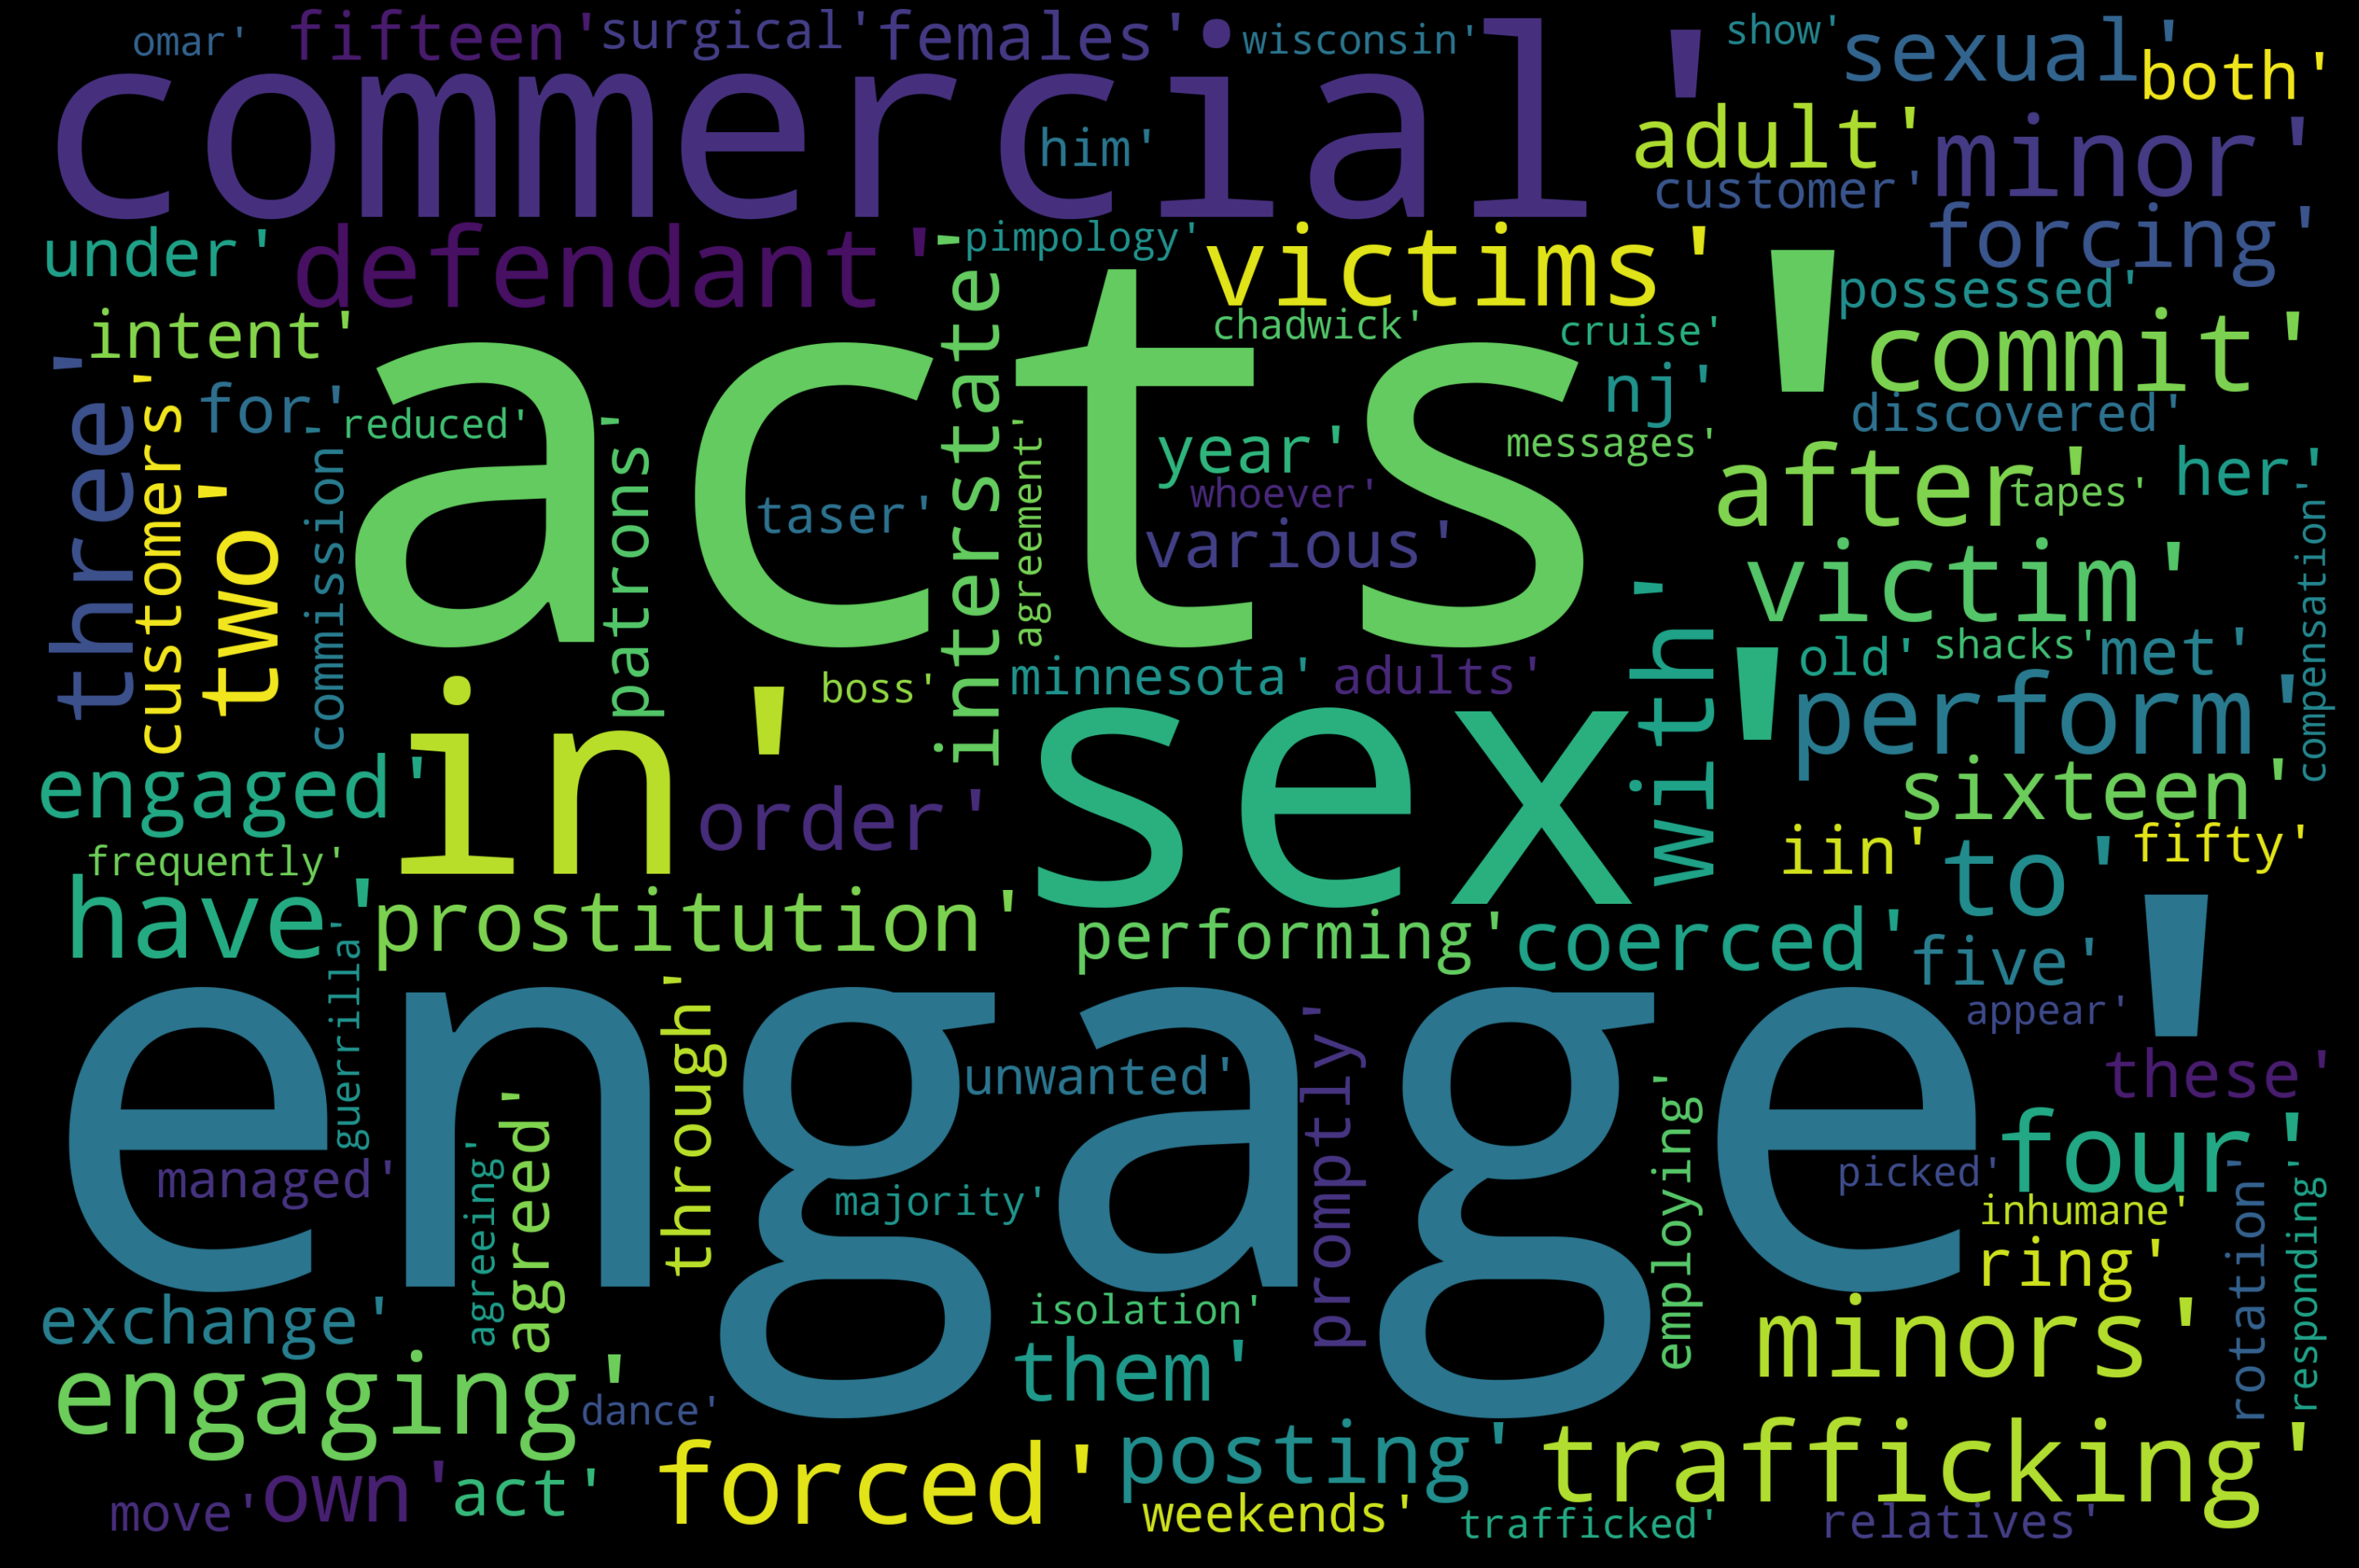

In [177]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num3'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
# plt.show()
plt.savefig('negative_2.jpg')

In [173]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num4'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

KeyError: 'Cluster num4'

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = top_words['Cluster num5'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()